Weed Detection Using Deep Learning

This script implements a Convolutional Neural Network (CNN) for classifying different types of plants
and weeds in agricultural images. It includes data preprocessing, model training, and evaluation
with comprehensive visualization tools.

The model can classify images into four categories:
- Broadleaf weeds
- Grass weeds
- Soil
- Soybean plants

`Author: Pouryare`

`Date: 2024-10-26`

# Downloading Dataset

In [1]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [7]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('fpeccia/weed-detection-in-soybean-crops', path="/content/drive/MyDrive/ML/weed-detection-in-soybean-crops", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/fpeccia/weed-detection-in-soybean-crops


# Step 1: Import Required Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Any

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# Evaluation metrics imports
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Step 2: Configure GPU and Set Global Parameters

In [2]:
# Define model parameters
# These parameters affect the model's architecture and training process
BATCH_SIZE: int = 512        # Number of images processed in each training step
IMAGE_SIZE: int = 128        # Size of input images (128x128 pixels)
INPUT_SHAPE: Tuple[int, int, int] = (128, 128, 3)  # (height, width, channels)
NUM_CLASSES: int = 4         # Number of plant categories
EPOCHS: int = 20             # Number of training cycles
VALIDATION_SPLIT: float = 0.2  # Portion of data used for validation

In [3]:
# File path
MODEL_FINAL_PATH: str = '/content/drive/MyDrive/ML/weed-detection-in-soybean-crops/weed_detection.keras'

In [4]:
# Configure mixed precision training
mixed_precision_policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(mixed_precision_policy)

# Step 3: Data Visualization Functions

In [5]:
def plot_sample_images(dataset: tf.data.Dataset, class_names: List[str], num_samples: int = 16) -> None:
    """Display a grid of sample images from the dataset."""
    images, labels = next(iter(dataset.unbatch().batch(num_samples)))

    plt.figure(figsize=(15, 15))
    for i in range(min(num_samples, len(images))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_training_history(history: Any) -> None:
    """Plot training and validation metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray,
                         class_names: List[str]) -> None:
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curves(y_true: np.ndarray, y_pred_proba: np.ndarray,
                    class_names: List[str]) -> None:
    """Plot ROC curves."""
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

# Step 4: Data Pipeline

In [6]:
def read_image(file_path):
    """Read image using OpenCV."""
    # Read image in BGR format
    img = cv2.imread(file_path.numpy().decode())
    # Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    # Normalize
    img = img.astype(np.float32) / 255.0
    return img

def process_path(file_path, label):
    """Load and process image file."""
    # Convert to numpy and process using OpenCV
    img = tf.py_function(read_image, [file_path], tf.float32)
    # Ensure shape is set
    img.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return img, label

def create_datasets(img_dir: str):
    """Create training and validation datasets."""
    AUTOTUNE = tf.data.AUTOTUNE

    class_dirs = [d for d in os.listdir(img_dir)
                 if os.path.isdir(os.path.join(img_dir, d))]
    class_dirs.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_dirs)}

    all_paths = []
    all_labels = []

    print("Loading dataset from directories:")
    for class_name in class_dirs:
        class_dir = os.path.join(img_dir, class_name)
        class_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                      if f.lower().endswith('.tif')]
        class_labels = [class_to_idx[class_name]] * len(class_files)

        print(f"{class_name}: {len(class_files)} images")
        all_paths.extend(class_files)
        all_labels.extend(class_labels)

    print(f"Total images: {len(all_paths)}")

    all_labels = tf.keras.utils.to_categorical(all_labels, num_classes=NUM_CLASSES)

    # Split train/validation
    indices = np.random.permutation(len(all_paths))
    n_val = int(len(indices) * VALIDATION_SPLIT)
    val_idx, train_idx = indices[:n_val], indices[n_val:]

    train_paths = [all_paths[i] for i in train_idx]
    train_labels = all_labels[train_idx]
    val_paths = [all_paths[i] for i in val_idx]
    val_labels = all_labels[val_idx]

    print(f"\nSplit sizes:")
    print(f"Training: {len(train_paths)} images")
    print(f"Validation: {len(val_paths)} images")

    # Create training dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    train_ds = train_ds.cache()
    train_ds = train_ds.shuffle(1000, reshuffle_each_iteration=True)
    train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.batch(BATCH_SIZE)
    train_ds = train_ds.prefetch(AUTOTUNE)

    # Create validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    val_ds = val_ds.cache()
    val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE)
    val_ds = val_ds.prefetch(AUTOTUNE)

    return train_ds, val_ds, class_dirs

# Step 5: Create and Compile Model

In [7]:
def create_model() -> Sequential:
    """
    Create and compile the CNN model for weed detection.

    Returns:
        Compiled Keras Sequential model
    """
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape=INPUT_SHAPE))

    # First convolutional block
    model.add(Conv2D(16, (3,3), activation="relu"))
    model.add(MaxPooling2D((2,2)))

    # Second convolutional block
    model.add(Conv2D(16, (3,3), activation="relu"))
    model.add(MaxPooling2D((2,2)))

    # Third convolutional block
    model.add(Conv2D(32, (3,3), activation="relu"))
    model.add(MaxPooling2D((2,2)))

    # Fourth convolutional block
    model.add(Conv2D(32, (3,3), activation="relu"))
    model.add(MaxPooling2D((2,2)))

    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Step 6: Training and Evaluation

In [8]:
img_dir = '/content/drive/MyDrive/ML/weed-detection-in-soybean-crops/dataset'

# Create data generators
train_ds, val_ds, class_names = create_datasets(img_dir)

Loading dataset from directories:
broadleaf: 1191 images
grass: 3520 images
soil: 3249 images
soybean: 7376 images
Total images: 15336

Split sizes:
Training: 12269 images
Validation: 3067 images


In [9]:
# Print dataset information
print(f"\nClasses found: {class_names}")
print("Dataset sizes:")
print(f"Training steps per epoch: {len(train_ds)}")
print(f"Validation steps per epoch: {len(val_ds)}")


Classes found: ['broadleaf', 'grass', 'soil', 'soybean']
Dataset sizes:
Training steps per epoch: 24
Validation steps per epoch: 6



Displaying sample images...


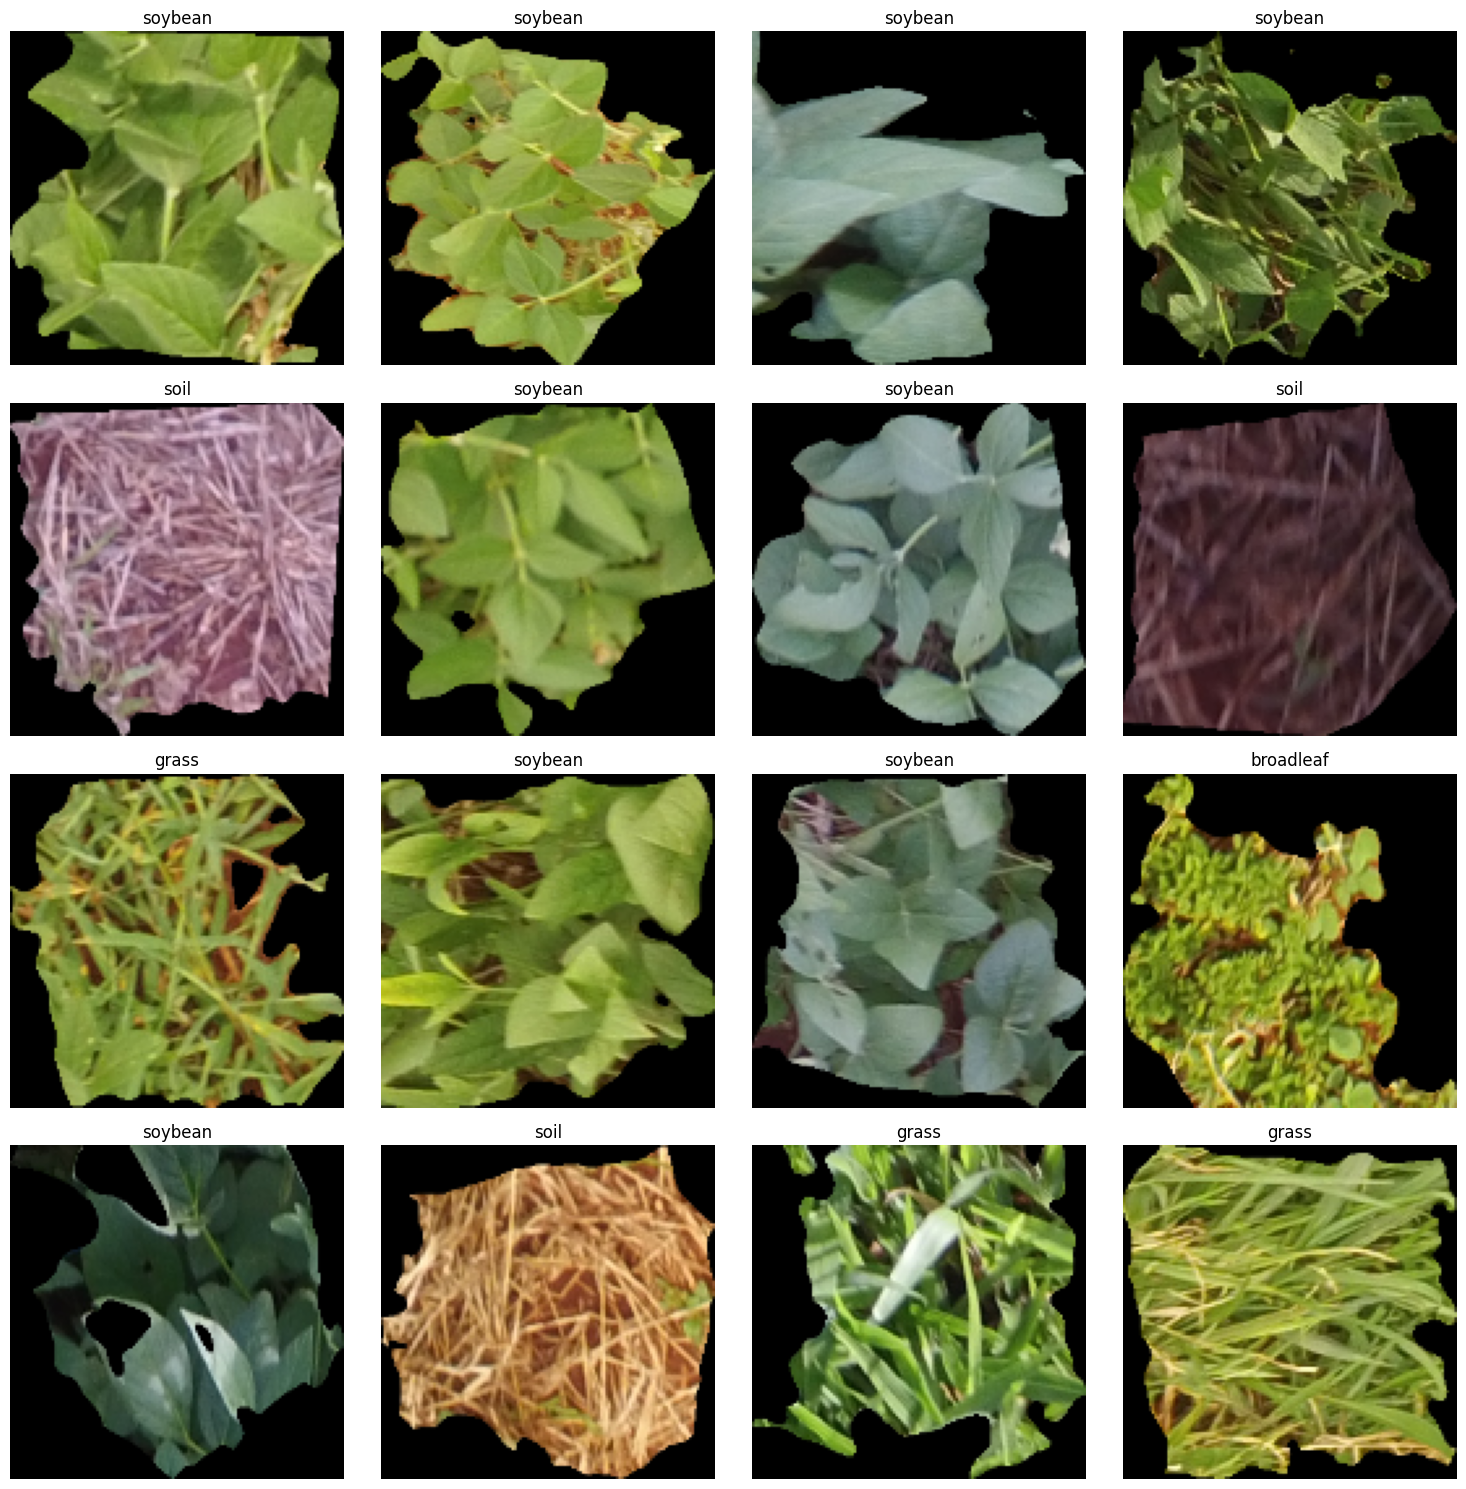

In [10]:
# Display sample images
print("\nDisplaying sample images...")
plot_sample_images(train_ds, class_names)

In [11]:
# Create and compile model
print("\nCreating and compiling model...")
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = create_model()
model.summary()


Creating and compiling model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,852 (1.19 MB)

 Trainable params: 312,852 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train model
print("\nStarting model training...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)


Starting model training...
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 189s 8s/step - accuracy: 0.5053 - loss: 1.1618 - val_accuracy: 0.7861 - val_loss: 0.5597
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7977 - loss: 0.5312 - val_accuracy: 0.8151 - val_loss: 0.4789
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8241 - loss: 0.4424 - val_accuracy: 0.8432 - val_loss: 0.3925
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8389 - loss: 0.4029 - val_accuracy: 0.8161 - val_loss: 0.4384
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8417 - loss: 0.3966 - val_accuracy: 0.8591 - val_loss: 0.3507
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8520 - loss: 0.3512 - val_accuracy: 0.8624 - val_loss: 0.3283
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8648 - loss: 0.3144 - val_accuracy: 0.8738 - val_loss: 0.3046
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8784 - loss: 0.2963 - val


Plotting training history...


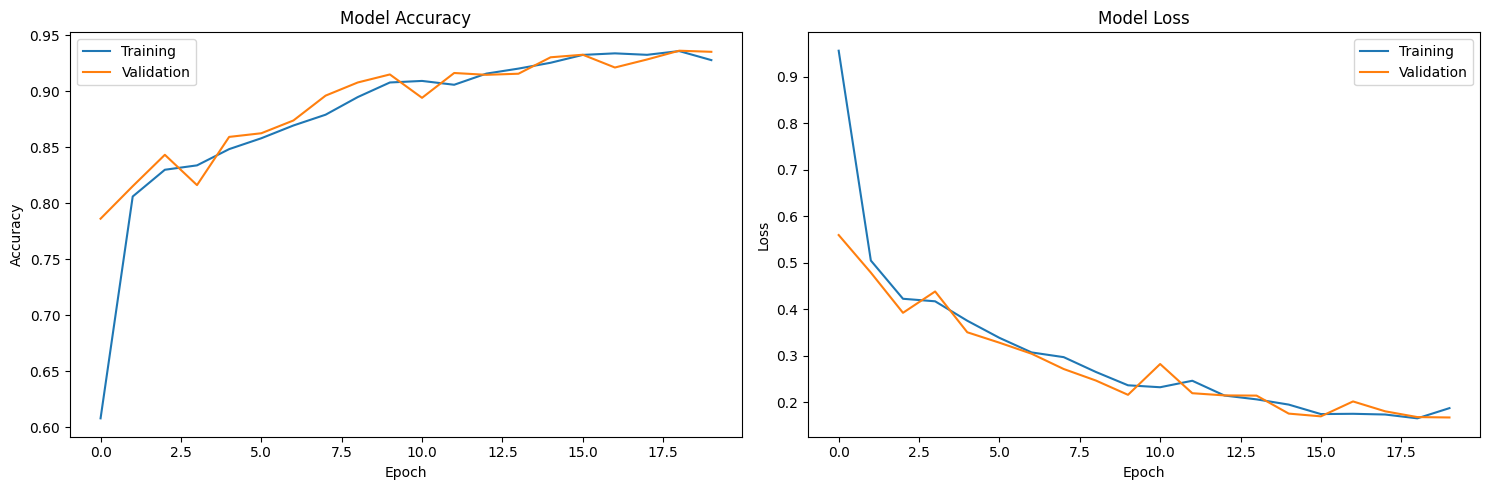

In [13]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(history)

In [14]:
# Generate predictions and evaluate
print("\nGenerating predictions...")
# Get predictions in one pass
val_predictions = model.predict(val_ds, verbose=1)


Generating predictions...
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


In [15]:
# Get validation labels from the dataset
val_true = np.concatenate([labels for images, labels in val_ds], axis=0)

In [16]:
# Calculate class predictions
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(val_true, axis=1)


Plotting confusion matrix...


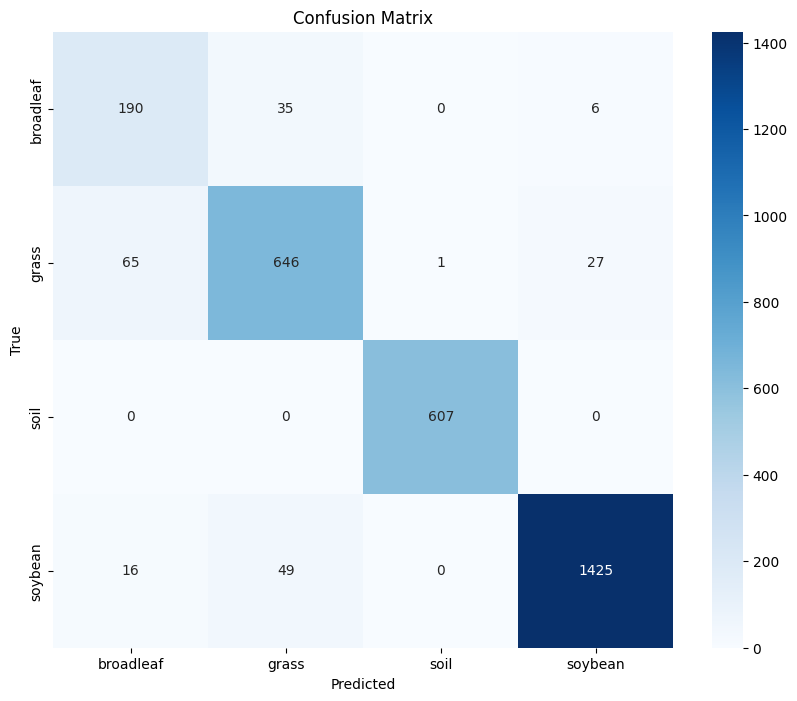

In [17]:
# Plot evaluation metrics
print("\nPlotting confusion matrix...")
plot_confusion_matrix(val_true_classes, val_pred_classes, class_names)


Plotting ROC curves...


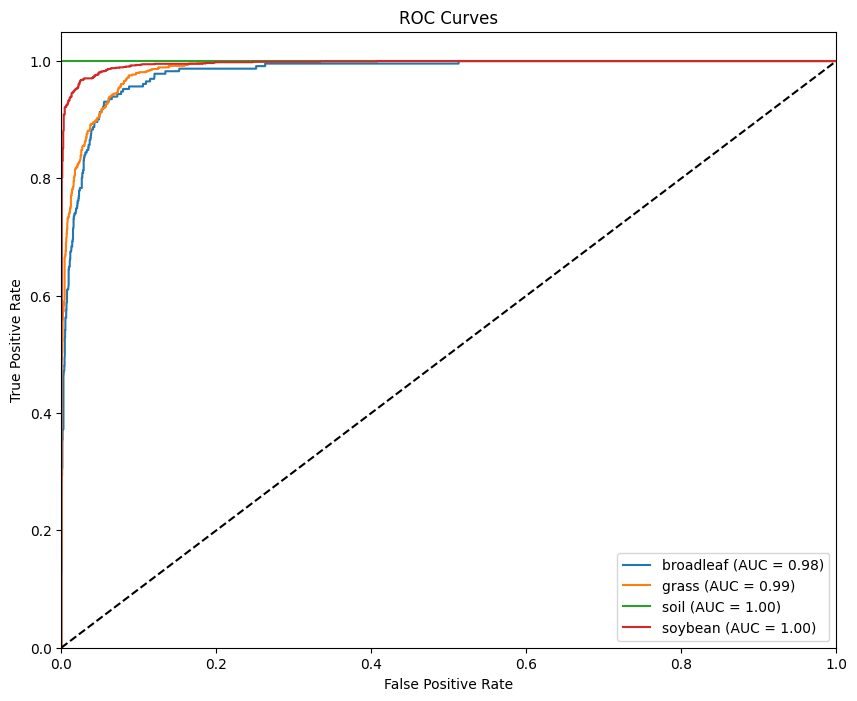

In [18]:
print("\nPlotting ROC curves...")
plot_roc_curves(val_true, val_predictions, class_names)

In [19]:
# Print classification report
print("\nClassification Report:")
print(classification_report(val_true_classes, val_pred_classes,
                          target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

   broadleaf       0.70      0.82      0.76       231
       grass       0.88      0.87      0.88       739
        soil       1.00      1.00      1.00       607
     soybean       0.98      0.96      0.97      1490

    accuracy                           0.94      3067
   macro avg       0.89      0.91      0.90      3067
weighted avg       0.94      0.94      0.94      3067



In [21]:
# Save model
model.save('weed_detection.keras')
print("\nTraining complete! Model saved as 'weed_detection.keras'")


Training complete! Model saved as 'weed_detection.keras'
